0.1
0.0
0.0
0.09991319444444445
0.0
0.0
0.09817715868537809
0.0
0.0
0.09636305807712801
0.0
0.0
0.09637822402797415
0.0
0.0
0.09286416978516851
0.0
0.0
0.09119067708927378
0.0
0.0
0.08611876038001195
0.0
0.0
0.08609758311081328
0.0
0.0
0.07938627356751382
0.0
0.0
0.07787897442307512
0.0
0.0
0.06987533795036788
0.0
0.0
0.06981925793008227
0.0
0.0
0.060338330337366394
0.0
0.0
0.05909020065459662
0.0
0.0
0.048661770438149676
0.0
0.0
0.048574389422333955
0.0
0.0
0.036921897418562846
0.0
0.0
0.03600950489177199
0.0
0.0
0.023811946326716765
0.0
0.0
0.023698796312476168
0.0
0.0
0.010605499788920735
0.0
0.0
0.010084308545475196
0.0
0.0
-0.0031191842812138375
0.0
0.0
-0.0032509911016739106
0.0
0.0
-0.01696744190074114
0.0
0.0
-0.017066440543563058
0.0
0.0
-0.030452886481441486
0.0
0.0
-0.030595104629767333
0.0
0.0
-0.04408121903152576
0.0
0.0
-0.04375334518570121
0.0
0.0
-0.056491262793307774
0.0
0.0
-0.05663502920246427
0.0
0.0
-0.06905457341925753
0.0
0.0
-0.06832165781471787
0.0
0.0
-0.07962

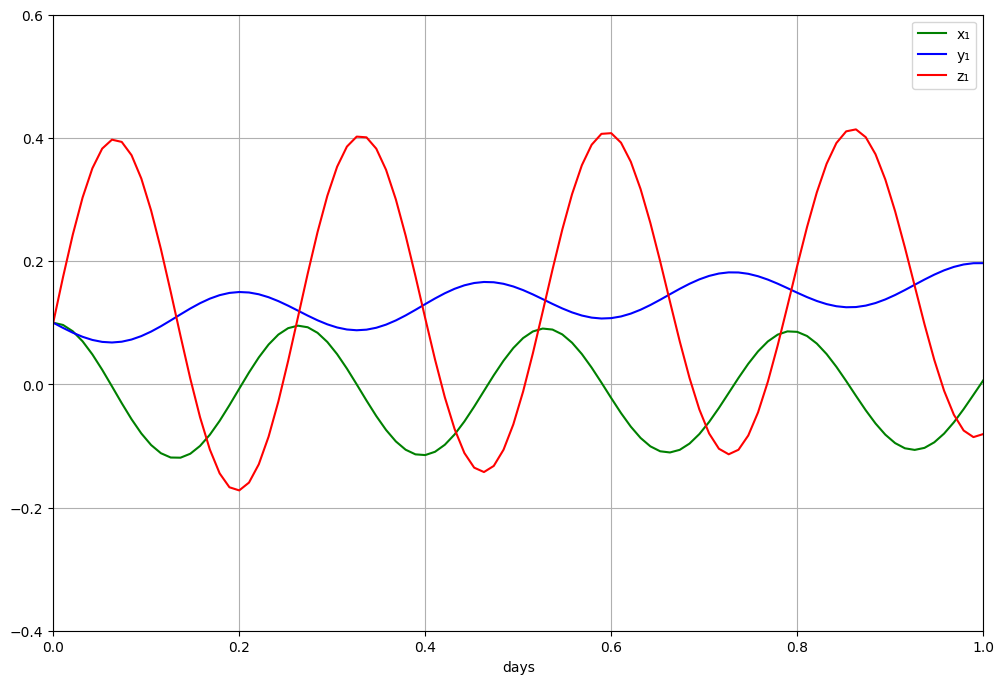

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import math

vetor_a = [1, 1, 3]
vetor_b = [
    1/2 * (vetor_a[0] - vetor_a[1] - vetor_a[2]),
    1/2 * (vetor_a[1] - vetor_a[2] - vetor_a[0]),
    1/2 * (vetor_a[2] - vetor_a[0] - vetor_a[1])
]
c = math.sqrt(3/4)

f_inv = 10800
vetor_h = [-1, 0, 0]
vetor_f = [0.1, 0, 0]
g_0 = 8
kappa_0 = 1/48
nu_0 = kappa_0

def derivatives(x, y, z):
    dx = np.zeros(3)
    dy = np.zeros(3)
    dz = np.zeros(3)

    for i in range(3):
        j = (i + 1) % 3
        k = (i + 2) % 3
        
        dx[i] = (vetor_a[i]*vetor_b[i]*x[j]*x[k] - 
                c*(vetor_a[i] - vetor_a[k])*y[j]*y[k] - 
                2*c*y[i]*y[k] - 
                nu_0*vetor_a[i]*x[i] +
                vetor_a[i]*y[i] - 
                vetor_a[i]*z[i])
        
        dy[i] = (-vetor_a[k]*vetor_b[k]*y[j]*y[k] - 
                vetor_a[j]*vetor_b[j]*y[j]*y[k] +
                c*(vetor_a[k] - vetor_a[j])*y[j]*y[k] - 
                vetor_a[i]*x[i] - 
                nu_0*vetor_a[i]*y[i])
        
        dz[i] = (-vetor_b[k]*y[j]*(z[k] - vetor_h[k]) -
                vetor_b[j]*(z[j] - vetor_h[j])*y[k] +
                c*y[j]*(z[k] - vetor_h[k]) -
                c*(z[j] - vetor_h[j])*y[k] +
                g_0*vetor_a[i]*x[i] -
                kappa_0*vetor_a[i]*z[i] + 
                vetor_f[i])

        print(x[i])
    return dx, dy, dz

def runge_kutta(dias):
    t_final = dias * 8
    dt_tau = 1/12
    n_steps = int(t_final / dt_tau)

    t = np.linspace(0, t_final, n_steps)
    x = np.zeros((n_steps, 3))
    y = np.zeros((n_steps, 3))
    z = np.zeros((n_steps, 3))

    x[0] = [0.1, 0, 0]
    y[0] = [0.1, 0, 0]
    z[0] = [0.1, 0, 0]

    for i in range(1, n_steps):
        dx1, dy1, dz1 = derivatives(x[i-1], y[i-1], z[i-1])
        k1x = dt_tau * dx1
        k1y = dt_tau * dy1
        k1z = dt_tau * dz1

        dx2, dy2, dz2 = derivatives(x[i-1] + k1x/2, y[i-1] + k1y/2, z[i-1] + k1z/2)
        k2x = dt_tau * dx2
        k2y = dt_tau * dy2
        k2z = dt_tau * dz2

        dx3, dy3, dz3 = derivatives(x[i-1] + k2x/2, y[i-1] + k2y/2, z[i-1] + k2z/2)
        k3x = dt_tau * dx3
        k3y = dt_tau * dy3
        k3z = dt_tau * dz3

        dx4, dy4, dz4 = derivatives(x[i-1] + k3x, y[i-1] + k3y, z[i-1] + k3z)
        k4x = dt_tau * dx4
        k4y = dt_tau * dy4
        k4z = dt_tau * dz4

        x[i] = x[i-1] + (k1x + 2*k2x + 2*k3x + k4x)/6
        y[i] = y[i-1] + (k1y + 2*k2y + 2*k3y + k4y)/6
        z[i] = z[i-1] + (k1z + 2*k2z + 2*k3z + k4z)/6

    t_days = t * 3/24
    return t_days, x, y, z

def plot2d(t, x, y, z, dias):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    ax.plot(t, x[:, 0], '-', linewidth=1.5, label='x₁', color='green')
    ax.plot(t, y[:, 0], '-', linewidth=1.5, label='y₁', color='blue')
    ax.plot(t, z[:, 0], '-', linewidth=1.5, label='z₁', color='red')

    ax.set_xlim(0, dias)
    ax.set_ylim(-0.4, 0.6)
    ax.set_xlabel('days')
    ax.grid(True)
    ax.legend()
    
    return fig, ax

def main():
    dias_simulacao = 1
    t, x, y, z = runge_kutta(dias_simulacao)
    plot2d(t, x, y, z, dias_simulacao)
    plt.show()

if __name__ == '__main__':
    main()

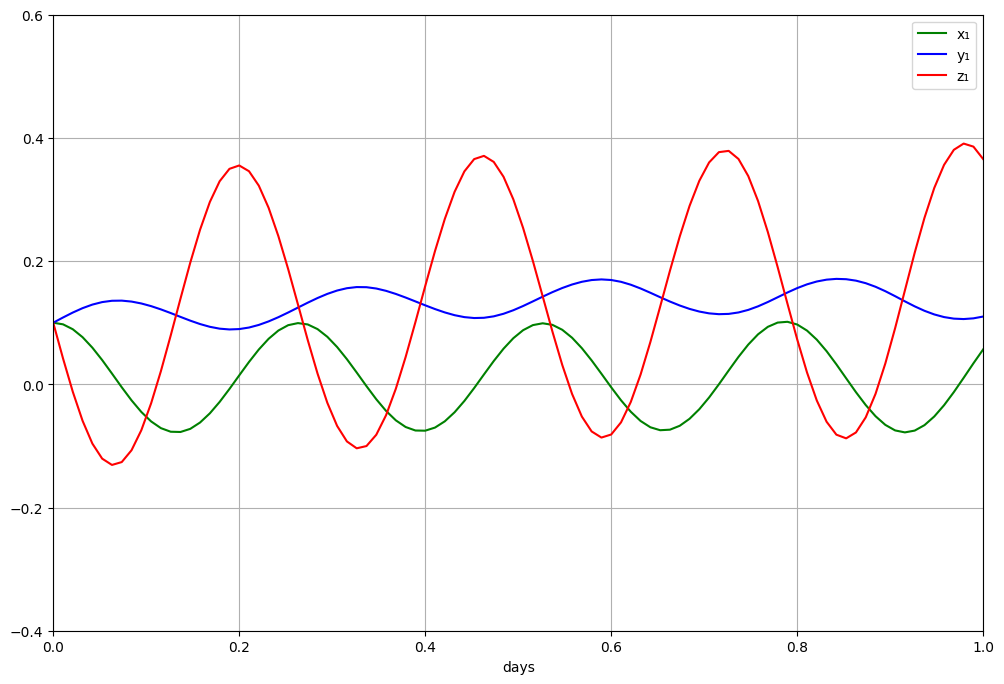

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import math

vetor_a = [1, 1, 3]
vetor_b = [
    1/2 * (vetor_a[0] - vetor_a[1] - vetor_a[2]),
    1/2 * (vetor_a[1] - vetor_a[2] - vetor_a[0]),
    1/2 * (vetor_a[2] - vetor_a[0] - vetor_a[1])
]
c = math.sqrt(3/4)

f_inv = 10800
vetor_h = [-1, 0, 0]
vetor_f = [0.1, 0, 0]
g_0 = 8
kappa_0 = 1/48
nu_0 = kappa_0

def calculate_uv(x, y):

    u = [
        -vetor_b[1] * x[0] + c * y[0],
        -vetor_b[2] * x[1] + c * y[1],
        -vetor_b[0] * x[2] + c * y[2]
    ]

    v = [
        -vetor_b[2] * x[0] - c * y[0],
        -vetor_b[0] * x[1] - c * y[1],
        -vetor_b[1] * x[2] - c * y[2]
    ]

    aux_x = [
        -vetor_a[0]*x[0],
        -vetor_a[1]*x[1],
        -vetor_a[2]*x[2]
    ]

    aux_y = [
        -vetor_a[0]*y[0],
        -vetor_a[0]*y[0],
        -vetor_a[0]*y[0],
    ]
    return u, v, aux_x, aux_y

def derivatives(x, y, z):
    u, v, aux_x, aux_y = calculate_uv(x, y)

    dx = np.zeros(3)
    dy = np.zeros(3)
    dz = np.zeros(3)

    for i in range(3):
        j = (i + 1) % 3
        k = (i + 2) % 3

        # Equação 40
        dx[i] = u[j]*u[k] + v[j]*v[k] - nu_0*vetor_a[i]*aux_x[i] + aux_y[i] + vetor_a[i]*z[i]

        # Equação 41
        dy[i] = u[j]*aux_y[k] + aux_y[j]*v[k] - aux_x[i] - nu_0*vetor_a[i]*aux_y[i]

        # Equação 42
        dz[i] = u[j]*(z[k] - vetor_h[k]) + (z[j] - vetor_h[j])*v[k] - g_0*vetor_a[i]*x[i] - kappa_0*vetor_a[i]*z[i] + vetor_f[i]

    return dx, dy, dz

def runge_kutta(dias):
    t_final = dias * 8
    dt_tau = 1/12
    n_steps = int(t_final / dt_tau)

    t = np.linspace(0, t_final, n_steps)
    x = np.zeros((n_steps, 3))
    y = np.zeros((n_steps, 3))
    z = np.zeros((n_steps, 3))

    x[0] = [0.1, 0, 0]
    y[0] = [0.1, 0, 0]
    z[0] = [0.1, 0, 0]

    for i in range(1, n_steps):
        dx1, dy1, dz1 = derivatives(x[i-1], y[i-1], z[i-1])
        k1x = dt_tau * dx1
        k1y = dt_tau * dy1
        k1z = dt_tau * dz1

        dx2, dy2, dz2 = derivatives(x[i-1] + k1x/2, y[i-1] + k1y/2, z[i-1] + k1z/2)
        k2x = dt_tau * dx2
        k2y = dt_tau * dy2
        k2z = dt_tau * dz2

        dx3, dy3, dz3 = derivatives(x[i-1] + k2x/2, y[i-1] + k2y/2, z[i-1] + k2z/2)
        k3x = dt_tau * dx3
        k3y = dt_tau * dy3
        k3z = dt_tau * dz3

        dx4, dy4, dz4 = derivatives(x[i-1] + k3x, y[i-1] + k3y, z[i-1] + k3z)
        k4x = dt_tau * dx4
        k4y = dt_tau * dy4
        k4z = dt_tau * dz4

        x[i] = x[i-1] + (k1x + 2*k2x + 2*k3x + k4x)/6
        y[i] = y[i-1] + (k1y + 2*k2y + 2*k3y + k4y)/6
        z[i] = z[i-1] + (k1z + 2*k2z + 2*k3z + k4z)/6

    t_days = t / 8
    return t_days, x, y, z

def plot2d(t, x, y, z, dias):
    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(t, x[:, 0], '-', linewidth=1.5, label='x₁', color='green')
    ax.plot(t, y[:, 0], '-', linewidth=1.5, label='y₁', color='blue')
    ax.plot(t, z[:, 0], '-', linewidth=1.5, label='z₁', color='red')

    ax.set_xlim(0, dias)
    ax.set_ylim(-0.4, 0.6)
    ax.set_xlabel('days')
    ax.grid(True)
    ax.legend()

    return fig, ax

def main():
    dias_simulacao = 1
    t, x, y, z = runge_kutta(dias_simulacao)

    plot2d(t, x, y, z, dias_simulacao)
    plt.show()

if __name__ == '__main__':
    main()

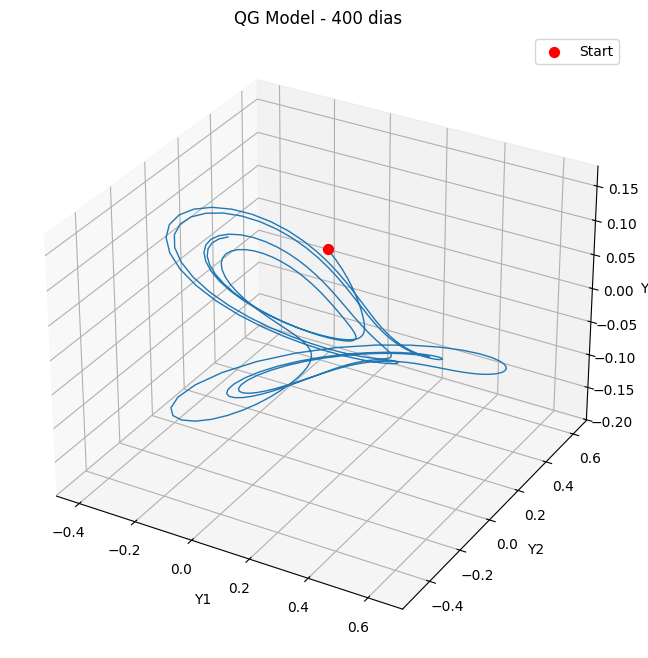

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import math

vetor_a = [1, 1, 3]
c = math.sqrt(3/4)
g_0 = 8
vetor_h = [-1, 0, 0]
kappa_0 = 1/48
nu_0 = kappa_0
vetor_f = [0.2, 0, 0]

def qg_model(y):
   dy = np.zeros(3)
   for i in range(3):
       j = (i + 1) % 3
       k = (i + 2) % 3
       dy[i] = (g_0*c*(vetor_a[k] - vetor_a[j])*y[j]*y[k]
               - vetor_a[i]*(vetor_a[i]*g_0*nu_0 + kappa_0)*y[i]
               - c*vetor_h[k]*y[j] + c*vetor_h[j]*y[k] + vetor_f[i]) / (vetor_a[i]*g_0 + 1)
   return dy

def rk4(f, y0, t):
   n = len(t)
   y = np.zeros((n, len(y0)))
   y[0] = y0
   dt = 1

   for i in range(n-1):
       k1 = f(y[i])
       k2 = f(y[i] + k1 * dt/2)
       k3 = f(y[i] + k2 * dt/2)
       k4 = f(y[i] + k3 * dt)
       y[i+1] = y[i] + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

   return y

def plot3d(dias, y0):
   t = np.arange(0, dias)
   sol = rk4(qg_model, y0, t)

   fig = plt.figure(figsize=(10, 8))
   ax = fig.add_subplot(111, projection='3d')

   ax.plot(sol[:,0], sol[:,1], sol[:,2], lw=1)
   ax.scatter(sol[0,0], sol[0,1], sol[0,2], c='r', s=50, label='Start')

   ax.set_xlabel('Y1')
   ax.set_ylabel('Y2')
   ax.set_zlabel('Y3')
   ax.set_title(f'QG Model - {dias} dias')
   ax.legend()

   plt.show()

def main():
   dias = 400
   y0 = [0.1, 0.1, 0.1]
   plot3d(dias, y0)

if __name__ == "__main__":
   main()